In [1]:
import os, zipfile, random, json, time, itertools, gc, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict

# I Used GPU which is faster than cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    torch.backends.cudnn.benchmark = True

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_everything(42)


Using device: cuda


In [2]:
#DATA IMPORT 
ZIP_PATH = Path("archive.zip")
EXTRACT_DIR = Path("data_raw")
EXTRACT_DIR.mkdir(exist_ok=True)

if ZIP_PATH.exists() and not any(EXTRACT_DIR.iterdir()):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
    print("Unzipped to:", EXTRACT_DIR.resolve())
else:
    print("Using existing extracted data at:", EXTRACT_DIR.resolve())

valid_exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

def looks_like_class_dir(p: Path, min_images=5):
    if not p.is_dir(): return False
    cnt = 0
    for f in p.rglob("*"):
        if f.is_file() and f.suffix.lower() in valid_exts:
            cnt += 1
            if cnt >= min_images: return True
    return False

def auto_find_dataset_root(root: Path):
    candidates = []
    for dirpath, dirnames, _ in os.walk(root):
        dirpath = Path(dirpath)
        subs = [dirpath/d for d in dirnames]
        class_like = [d for d in subs if looks_like_class_dir(d)]
        if len(class_like) >= 2:
            candidates.append(dirpath)
    candidates = sorted(candidates, key=lambda p: len(p.parts))
    return candidates[0] if candidates else None

DATA_ROOT = auto_find_dataset_root(EXTRACT_DIR)
assert DATA_ROOT is not None, "Could not detect dataset root. Set DATA_ROOT manually."
print("Detected dataset root:", DATA_ROOT)


Using existing extracted data at: C:\Users\Victory\data_raw
Detected dataset root: data_raw\plantvillage dataset


In [3]:
#CLEAN THE DATASET
bad = []
for cls in sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()]):
    for img in cls.rglob("*"):
        if img.is_file() and img.suffix.lower() in valid_exts:
            try:
                Image.open(img).verify()
            except (UnidentifiedImageError, OSError):
                bad.append(img)
for p in bad:
    p.unlink(missing_ok=True)
print(f"Removed {len(bad)} corrupt images.")

classes = [d.name for d in sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])]
counts = []
for c in classes:
    n = sum(1 for f in (DATA_ROOT/c).rglob("*") if f.is_file() and f.suffix.lower() in valid_exts)
    counts.append((c, n))
df_counts = pd.DataFrame(counts, columns=["class","count"]).sort_values("count", ascending=False)
df_counts.head(10)


Removed 0 corrupt images.


,class,count
2,segmented,54306
0,color,54305
1,grayscale,54305


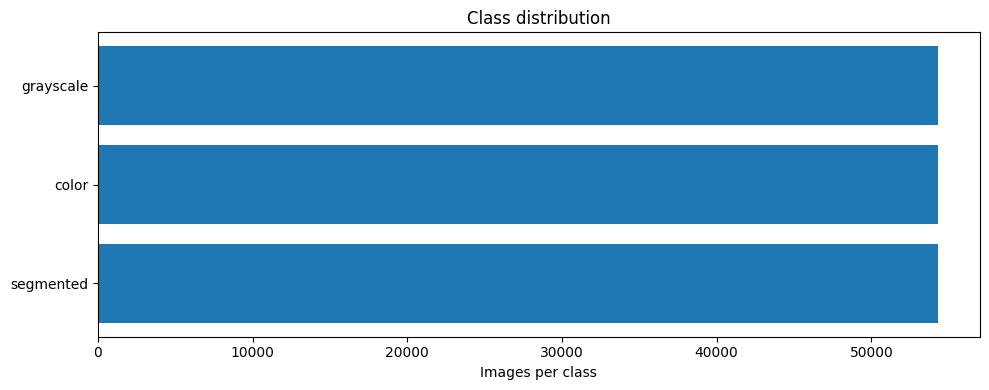

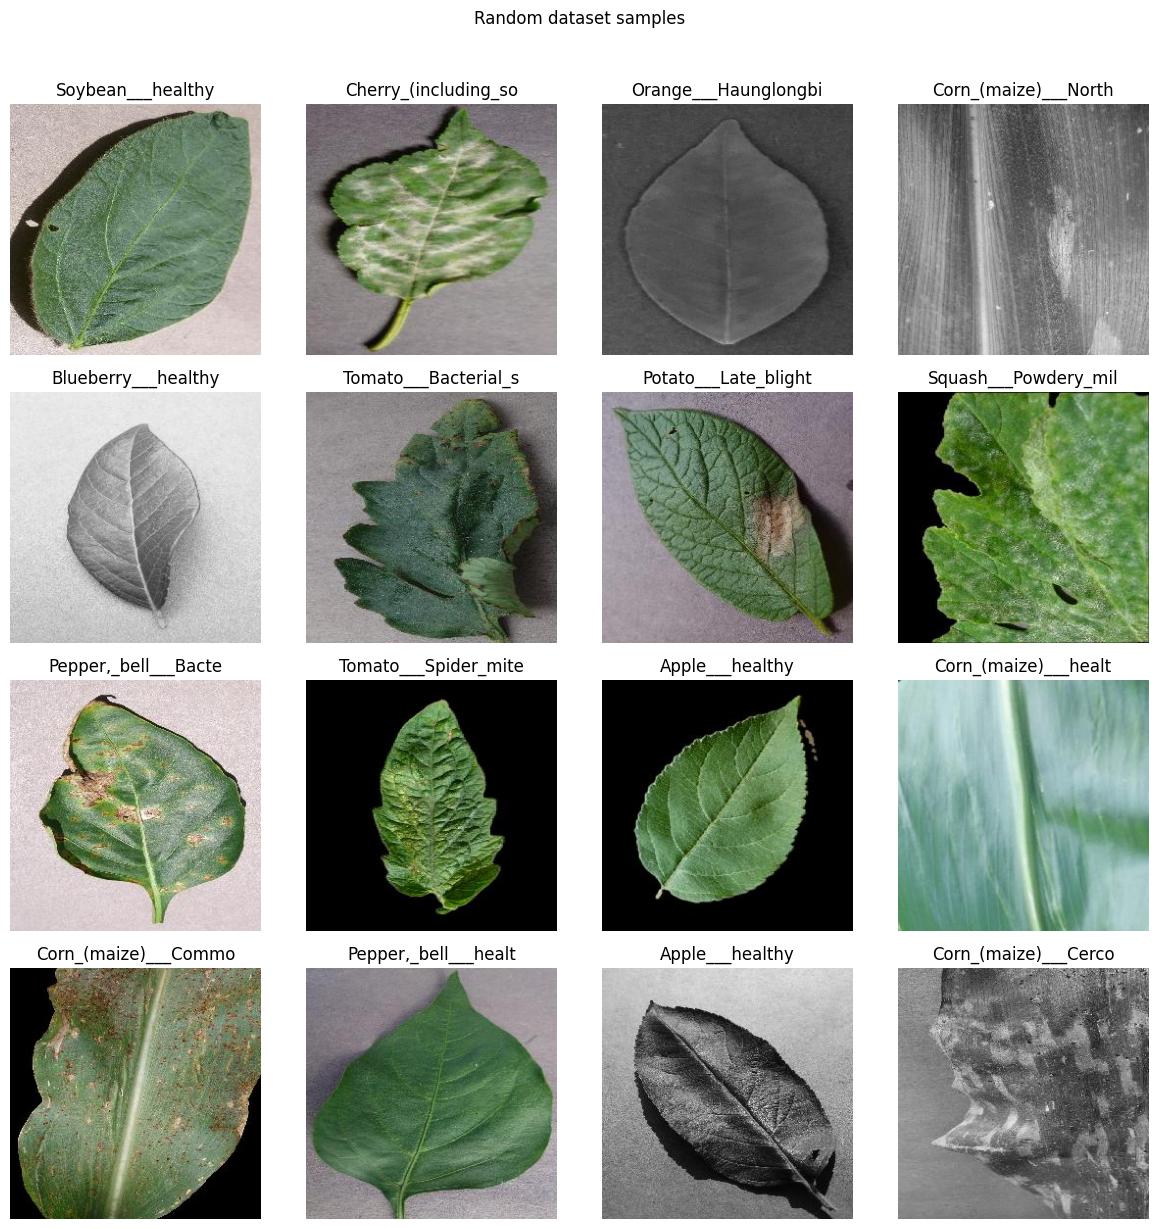

In [4]:
# Class distribution bar chart
plt.figure(figsize=(10, max(4, len(df_counts)*0.25)))
plt.barh(df_counts["class"], df_counts["count"])
plt.title("Class distribution"); plt.xlabel("Images per class"); plt.tight_layout()
plt.show()

# Random sample grid 
def show_random_images(root: Path, n=16):
    all_imgs = []
    for c in [d for d in root.iterdir() if d.is_dir()]:
        imgs = [p for p in c.rglob("*") if p.suffix.lower() in valid_exts]
        all_imgs.extend(imgs)
    sel = random.sample(all_imgs, k=min(n, len(all_imgs)))
    cols = 4; rows = int(np.ceil(len(sel)/cols))
    plt.figure(figsize=(12, 3*rows))
    for i, p in enumerate(sel, 1):
        plt.subplot(rows, cols, i)
        im = Image.open(p).convert("RGB")
        plt.imshow(im); plt.axis("off"); plt.title(p.parent.name[:20])
    plt.suptitle("Random dataset samples", y=1.02); plt.tight_layout(); plt.show()

show_random_images(DATA_ROOT, n=16)


In [5]:
# TRANSFORMS
IMG_SIZE = 160                  
BATCH_SIZE = 32
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
MAX_PER_CLASS = 250             

tfm_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
tfm_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

full_ds = datasets.ImageFolder(DATA_ROOT, transform=tfm_train)
print("Total images:", len(full_ds), "| Classes:", len(full_ds.classes))

def stratified_cap_indices(imagefolder, max_per_class=300, seed=42):
    if max_per_class is None:
        return list(range(len(imagefolder)))
    rng = random.Random(seed)
    by_class = defaultdict(list)
    for idx, (_, y) in enumerate(imagefolder.samples):
        by_class[y].append(idx)
    capped = []
    for y, idxs in by_class.items():
        rng.shuffle(idxs)
        capped.extend(idxs[:max_per_class])
    rng.shuffle(capped)
    return capped

cap_idx = stratified_cap_indices(full_ds, MAX_PER_CLASS)
ds_cap = Subset(full_ds, cap_idx)
y_cap = np.array([full_ds.targets[i] for i in cap_idx])
n_total = len(ds_cap)

sss_test = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SPLIT, random_state=42)
train_val_idx_rel, test_idx_rel = next(sss_test.split(np.zeros(n_total), y_cap))

y_train_val = y_cap[train_val_idx_rel]
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT/(1-TEST_SPLIT), random_state=42)
train_idx_rel2, val_idx_rel = next(sss_val.split(np.zeros(len(train_val_idx_rel)), y_train_val))

train_idx_cap = [cap_idx[i] for i in train_val_idx_rel[train_idx_rel2]]
val_idx_cap   = [cap_idx[i] for i in train_val_idx_rel[val_idx_rel]]
test_idx_cap  = [cap_idx[i] for i in test_idx_rel]

train_ds = Subset(datasets.ImageFolder(DATA_ROOT, transform=tfm_train), train_idx_cap)
val_ds   = Subset(datasets.ImageFolder(DATA_ROOT, transform=tfm_eval),  val_idx_cap)
test_ds  = Subset(datasets.ImageFolder(DATA_ROOT, transform=tfm_eval),  test_idx_cap)

print("Split sizes (capped):", len(train_ds), len(val_ds), len(test_ds))


Total images: 162916 | Classes: 3
Split sizes (capped): 524 113 113


In [6]:
# DATALOADERS + CLASS WEIGHTS
def compute_class_weights_from_subset(subset: Subset, n_classes: int):

    targets = [subset.dataset.samples[i][1] for i in subset.indices]
    counts = np.bincount(targets, minlength=n_classes)
    weights = 1. / (counts + 1e-9)
    weights = weights / weights.sum() * len(counts)
    sample_weights = [weights[t] for t in targets]
    return torch.DoubleTensor(sample_weights), torch.tensor(weights, dtype=torch.float32)

use_weighted_sampler = True
train_sampler = None
class_weights = torch.ones(len(full_ds.classes))
if use_weighted_sampler:
    sample_weights, class_weights = compute_class_weights_from_subset(train_ds, n_classes=len(full_ds.classes))
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    shuffle_train = False
else:
    shuffle_train = True

NUM_WORKERS = 4
PIN = True; PERSISTENT = True

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=shuffle_train, sampler=train_sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=PERSISTENT)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=PERSISTENT)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=PERSISTENT)

print("Loaders ready.")


Loaders ready.


In [7]:
# MODELS
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(256, num_classes))
    def forward(self, x):
        x = self.features(x); x = x.view(x.size(0), -1)
        return self.classifier(x)

def build_model(name: str, num_classes: int, pretrained=True, freeze_backbone=False):
    name = name.lower()
    if name == "custom_cnn":
        model = SmallCNN(num_classes)
    elif name == "resnet18":
        m = resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        model = m
    elif name == "mobilenet_v2":
        m = mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
        m.classifier[1] = nn.Linear(m.last_channel, num_classes)
        model = m
    elif name == "efficientnet_b0":
        m = efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        model = m
    else:
        raise ValueError(f"Unknown model: {name}")

    if freeze_backbone and name != "custom_cnn":
        for p in model.parameters(): p.requires_grad = False
        if hasattr(model, "fc") and isinstance(model.fc, nn.Linear):
            model.fc.weight.requires_grad = True; model.fc.bias.requires_grad = True
        elif hasattr(model, "classifier"):
            for p in model.classifier.parameters(): p.requires_grad = True
    return model

def count_params(model):
    t = sum(p.numel() for p in model.parameters())
    tr = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return t, tr


In [8]:
#TRAIN / EVALUATION
from torch.amp import GradScaler, autocast

def evaluate(model, loader, criterion, device=DEVICE):
    model.eval()
    tot=correct=losssum=0.0
    all_pred=[]; all_true=[]
    with torch.no_grad():
        for xb,yb in loader:
            xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
            logits = model(xb); loss = criterion(logits, yb)
            losssum += loss.item()*xb.size(0)
            pred = logits.argmax(1)
            correct += (pred==yb).sum().item(); tot += yb.size(0)
            all_pred.append(pred.cpu().numpy()); all_true.append(yb.cpu().numpy())
    avg = losssum/tot; acc = correct/tot
    all_pred = np.concatenate(all_pred); all_true = np.concatenate(all_true)
    return avg, acc, all_pred, all_true

def plot_confusion_matrix_safe(y_true, y_pred, class_names, normalize=True, title='Confusion Matrix'):
    n = len(class_names)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n)))
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True)+1e-12)
    base = 0.35 if n > 20 else 0.5
    size = max(8, min(18, base*n))
    plt.figure(figsize=(size, size*0.8))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(n)
    plt.xticks(ticks, class_names, rotation=90, fontsize=8 if n>20 else 10)
    plt.yticks(ticks, class_names, fontsize=8 if n>20 else 10)
    if n <= 20:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max()/2.0
        for i in range(n):
            for j in range(n):
                val = format(cm[i,j], fmt)
                plt.text(j,i,val, ha="center", color="white" if cm[i,j]>thresh else "black", fontsize=7)
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout(); plt.show(); plt.close('all')

def run_training_fast(model_name, outdir="runs_fast",
                      freeze_epochs=2, finetune_epochs=2, lr=3e-4, patience=2):
    out = Path(outdir); out.mkdir(parents=True, exist_ok=True)
    num_classes = len(full_ds.classes)
    model = build_model(model_name, num_classes, pretrained=True, freeze_backbone=True).to(DEVICE)
    if DEVICE.type == "cuda":
        model = model.to(memory_format=torch.channels_last)

    total_p, trainable_p = count_params(model)
    print(f"\n=== {model_name} ===")
    print(f"Params — total: {total_p:,} | trainable (frozen): {trainable_p:,}")

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scaler = GradScaler('cuda') if DEVICE.type == "cuda" else None

    best_val, bad = 0.0, 0
    best_path = out / f"{model_name}_best.pt"
    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    def train_epoch():
        model.train()
        tot=correct=losssum=0.0
        for xb,yb in train_loader:
            xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            if scaler:
                with autocast('cuda'):
                    logits = model(xb); loss = criterion(logits, yb)
                scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            else:
                logits = model(xb); loss = criterion(logits, yb)
                loss.backward(); opt.step()
            losssum += loss.item()*xb.size(0)
            correct += (logits.argmax(1)==yb).sum().item(); tot += yb.size(0)
        return losssum/tot, correct/tot

    # frozen
    for e in range(1, freeze_epochs+1):
        trL, trA = train_epoch()
        vaL, vaA, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        hist["train_loss"].append(trL); hist["train_acc"].append(trA)
        hist["val_loss"].append(vaL);   hist["val_acc"].append(vaA)
        print(f"[S1 {e}/{freeze_epochs}] train {trL:.4f}/{trA:.4f} | val {vaL:.4f}/{vaA:.4f}")
        if vaA > best_val:
            best_val = vaA; bad = 0
            torch.save({"model": model.state_dict(), "classes": full_ds.classes}, best_path)
        else:
            bad += 1
            if bad >= patience:
                print("Early stop (frozen)."); break

    #unfreeze backbone
    for p in model.parameters(): p.requires_grad = True
    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr*0.5)
    trainable_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Unfrozen. Trainable params:", f"{trainable_p:,}")

    bad = 0
    for e in range(1, finetune_epochs+1):
        trL, trA = train_epoch()
        vaL, vaA, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        hist["train_loss"].append(trL); hist["train_acc"].append(trA)
        hist["val_loss"].append(vaL);   hist["val_acc"].append(vaA)
        print(f"[S2 {e}/{finetune_epochs}] train {trL:.4f}/{trA:.4f} | val {vaL:.4f}/{vaA:.4f}")
        if vaA > best_val:
            best_val = vaA; bad = 0
            torch.save({"model": model.state_dict(), "classes": full_ds.classes}, best_path)
        else:
            bad += 1
            if bad >= patience:
                print("Early stop (finetune)."); break

    # Test on CPU 
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    ckpt = torch.load(best_path, map_location="cpu")
    model_cpu = build_model(model_name, num_classes=len(full_ds.classes), pretrained=False, freeze_backbone=False)
    model_cpu.load_state_dict(ckpt["model"]); model_cpu.eval()

    crit = nn.CrossEntropyLoss()
    teL, teA, y_pred, y_true = evaluate(model_cpu, test_loader, crit, device="cpu")
    print(f"[{model_name}] Test loss {teL:.4f} | Test acc {teA:.4f}")

    # Classification report
    rep_txt = classification_report(y_true, y_pred, target_names=full_ds.classes, digits=4, zero_division=0)
    print(rep_txt)
    rep_path = out / f"{model_name}_classification_report.txt"
    with open(rep_path, "w") as f: f.write(rep_txt)

    # Confusion matrix
    cm_path = out / f"{model_name}_confusion_matrix.png"
    plot_confusion_matrix_safe(y_true, y_pred, class_names=full_ds.classes, normalize=True,
                               title=f"{model_name} — Normalized Confusion Matrix")
    plt.savefig(cm_path, dpi=200, bbox_inches="tight"); plt.close()


    plt.figure(); plt.plot(hist["train_acc"], label="train_acc"); plt.plot(hist["val_acc"], label="val_acc")
    plt.title(f"{model_name} Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout()
    plt.savefig(out / f"{model_name}_acc_curve.png", dpi=200); plt.close()

    plt.figure(); plt.plot(hist["train_loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"{model_name} Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
    plt.savefig(out / f"{model_name}_loss_curve.png", dpi=200); plt.close()

    return {
        "model": model_name,
        "total_params": int(total_p),
        "trainable_params": int(trainable_p),
        "best_val_acc": float(best_val),
        "test_acc": float(teA),
        "report_file": str(rep_path),
        "confusion_matrix_file": str(cm_path),
    }



=== mobilenet_v2 ===
Params — total: 2,227,715 | trainable (frozen): 3,843
[S1 1/2] train 0.9545/0.5344 | val 0.7898/0.7434
[S1 2/2] train 0.6274/0.8721 | val 0.5400/0.9115
Unfrozen. Trainable params: 2,227,715
[S2 1/2] train 0.1545/0.9752 | val 0.0872/0.9646
[S2 2/2] train 0.0565/0.9790 | val 0.0565/0.9823


C:\Users\Victory\AppData\Local\Temp\ipykernel_2528\297989615.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location="cpu")


[mobilenet_v2] Test loss 0.0342 | Test acc 0.9912
              precision    recall  f1-score   support

       color     1.0000    0.9730    0.9863        37
   grayscale     1.0000    1.0000    1.0000        38
   segmented     0.9744    1.0000    0.9870        38

    accuracy                         0.9912       113
   macro avg     0.9915    0.9910    0.9911       113
weighted avg     0.9914    0.9912    0.9911       113



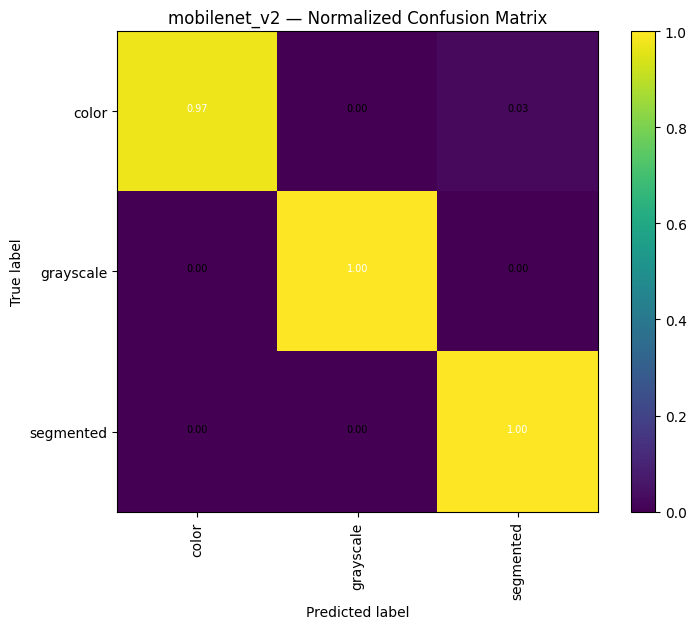

{
  "mobilenet_v2": {
    "model": "mobilenet_v2",
    "total_params": 2227715,
    "trainable_params": 2227715,
    "best_val_acc": 0.9823008849557522,
    "test_acc": 0.9911504424778761,
    "report_file": "runs_fast\\mobilenet_v2_classification_report.txt",
    "confusion_matrix_file": "runs_fast\\mobilenet_v2_confusion_matrix.png"
  }
}


In [9]:
# RUN 
MODELS = ["mobilenet_v2"]  
OUTDIR = "runs_fast"

summary = {}
for m in MODELS:
    stats = run_training_fast(m, outdir=OUTDIR, freeze_epochs=2, finetune_epochs=2,
                              lr=3e-4, patience=2)
    summary[m] = stats

with open(Path(OUTDIR)/"summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print(json.dumps(summary, indent=2))


Best model: mobilenet_v2


C:\Users\Victory\AppData\Local\Temp\ipykernel_2528\3294584208.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(Path(OUTDIR)/f"{best_model_name}_best.pt"

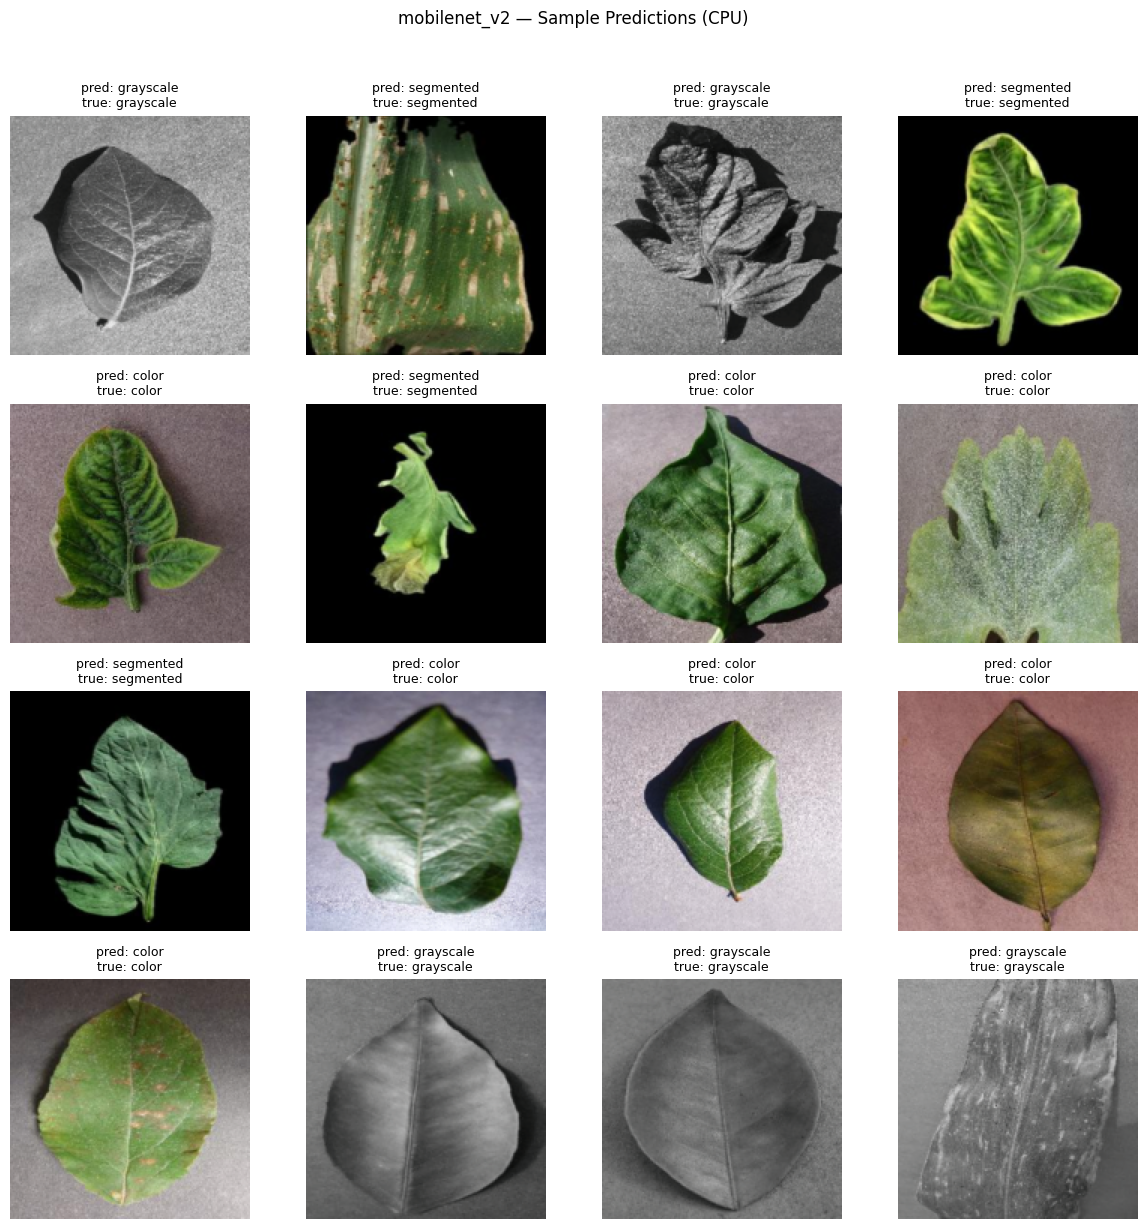

In [10]:
# SAMPLE PREDICTIONS GRID 
best_model_name = max(summary, key=lambda k: summary[k]["test_acc"])
print("Best model:", best_model_name)

ckpt = torch.load(Path(OUTDIR)/f"{best_model_name}_best.pt", map_location="cpu")
classes = ckpt["classes"]
model = build_model(best_model_name, num_classes=len(classes), pretrained=False)
model.load_state_dict(ckpt["model"]); model.eval()

k = min(16, len(test_ds))
indices = random.sample(list(range(len(test_ds))), k=k)
cols = 4; rows = int(np.ceil(k/cols))
plt.figure(figsize=(12, 3*rows))

to_pil = transforms.ToPILImage()
unnorm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                              std=[1/0.229, 1/0.224, 1/0.225])

with torch.inference_mode():
    for i, idx in enumerate(indices, 1):
        x, y = test_ds[idx]
        logits = model(x.unsqueeze(0))
        pred = int(logits.argmax(1))
        x_disp = unnorm(x).clamp(0,1)
        plt.subplot(rows, cols, i)
        plt.imshow(to_pil(x_disp)); plt.axis("off")
        plt.title(f"pred: {classes[pred]}\ntrue: {classes[y]}", fontsize=9)

plt.suptitle(f"{best_model_name} — Sample Predictions (CPU)", y=1.02)
plt.tight_layout(); plt.show(); plt.close('all')
